# Current Sensing

### Current Shunts
Now that we got past the boring stuff we can finally get to the best part of designing a brushless motor controller, current sensing!

In order to do FOC and prevent our driver from drawing to much current (overcurrent protection) we need a way of accurately measuring the current being sent to the motor.

One way of doing this is by [running the current through a wire then using a inductive or hall effect sensor to measure the magnetic field](https://www.nktechnologies.com/engineering-resources/current-sensing-theory/) created by it (right hand rule :D).

However, with the currents we are working with on the motor driver and the space constraints we have, its not really feasible to do that.

A more simple way of measuring the current is by taking a really small resistor (often called a shunt resistor), putting that in series with the load that is drawing current, and measuring the voltage drop across it. If we know the value of the resistor and the voltage drop across it we can calculate the current flowing through it using Ohm's law.

#### Resistor Selection
One important thing to note is we can't just choose any resistor to be our current shunt.

Generally, we want current shunts to have a really small value, so they drop a very small voltage over them and don't dissipate a lot of power. We also want them to be very prices as if they drift in resistance value they will completely throw off our current measurements.

Since we know our $I_{max} = 60A$ we can set a desired power dissipated at 60A and size everything accordingly.

Lets say we want a maximum of around 4W to be dissipated through the shunt when the max current flows through it. We can easily calculate the desired shunt resistance to be:
$$P = I^2 \cdot R$$
$$R = \frac{P}{I^2}$$
$$R = \frac{4W}{60A^2}$$
$$R = 0.00111\Omega$$

This is a really low resistance value and its usually hard to get the exact resistance we need when resistors are that small. To work around this we can round this down (meaning less power will be dissipated but also less voltage will be dropped) to the closest available size: $0.001\Omega$

This gives us a power dissipated of
$$P = I^2 \cdot R$$
$$P = 60A^2 \cdot 0.001\Omega$$
$$P = 3.6W$$

Which is within our max desired dissipation.

Over this resistance, we can also calculated the voltage dropped at $I_{max} = 60A$:
$$V = I \cdot R$$
$$V = 60A \cdot 0.001\Omega$$
$$V = 0.06V$$
$$V = 60mv$$

This is a really small voltage value (as a result of not wanting to dissipate too much power over the resistor) so to read it with our microcontroller we will have to pass the signal through an amplifier before it goes into the ADC. But more on that later.

In terms of actual component choice, I decided on the [BVS-A-R001-1.0](https://www.isabellenhuetteusa.com/wp-content/uploads/2020/05/BVS.pdf) because of it's very low temp-co ($\pm50 \frac{ppm}{\degree C}$) and high precision ($\pm1\%$). Having a low resistor temp-co is very important as we don't want the shunt measurement to drift much as the controller heats up.

The max power dissipation of the BVS (8W) is also well within our expected power dissipation at $I_{max} = 60A$.

### Op-Amp
Now that we have chosen our shunts, we can start specing the op-amp amplifier circuit.

Here the STSPIN guide on current sensing is very useful:
[https://www.st.com/resource/en/application_note/an5397-current-sensing-in-motion-control-applications-stmicroelectronics.pdf](https://www.st.com/resource/en/application_note/an5397-current-sensing-in-motion-control-applications-stmicroelectronics.pdf)

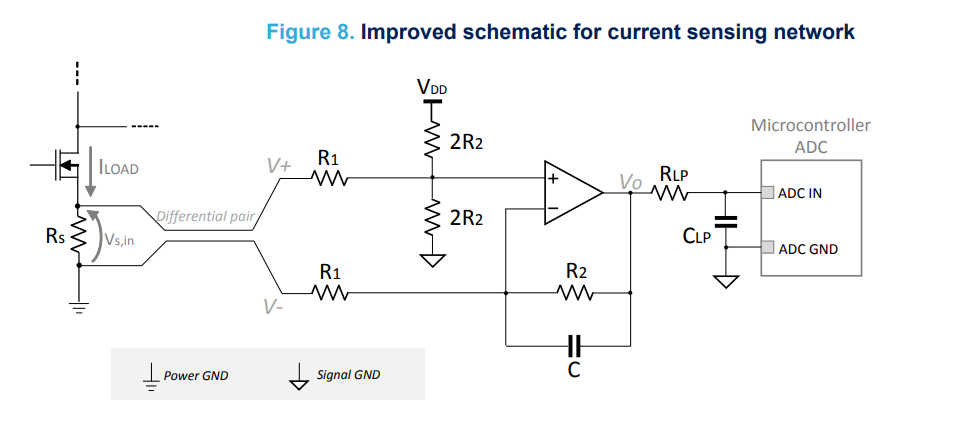

The first thing we need to calculate is the desired op-amp gain. This is essentially the amount the voltage from the shunt will be amplified by the op-amp to make it readable by the ADC.

Since the ADCs in the STSPIN operate from VDD (3.3V) to 0V, we want to set our gain to amplify our shunt voltage to that value.

Our max-gain becomes:
$$G_{max} = \frac{V_{DD}}{2 \cdot I_{max} \cdot R_S} \quad (6)$$

Note the two in the equation because we want to measure positive and negative currents.

$$G_{max} = \frac{3.3V}{2 \cdot 60A \cdot 0.001\Omega}$$
$$G_{max} = 27.5$$

If we allowing for margin on the signal we can aim for a gain of 25.
$$G = 25$$

Equation 13 then tells us
$$G = \frac{R_2}{R_1}$$

so if we choose $R_1 = 2k\Omega$, $R_2$ becomes
$$R_2 = G \cdot R_1$$
$$R_2 = 25k\Omega \cdot 2$$
$$R_2 = 50k\Omega$$

And,
$$2R_2 = 100k\Omega$$

